## Customer Churn Prediction - Bank

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix, classification_report 
import subprocess
import joblib
# Get multiple outputs in the same cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# Ignore all warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Reading the DataSet

In [2]:
dc = pd.read_csv("E:/AMotefaker/ABC/Data Analyst/Sales Data Analysis/Customer Churn Prediction - Bank/Churn_Modelling.csv") 

In [3]:
dc.head(5) 

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Exploratory Data Analysis

In [4]:
# Dimension of the dataset
dc.shape

(10000, 14)

In [5]:
# Describe all numerical columns
dc.describe(exclude= ['O'])

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [6]:
# Describe all categorical columns
dc.describe(include = ['O'])

,Surname,Geography,Gender
count,10000,10000,10000
unique,2932,3,2
top,Smith,France,Male
freq,32,5014,5457


In [7]:
# Checking number of unique customers in the dataset
dc.shape[0], dc.CustomerId.nunique()

(10000, 10000)

- This means each row corresponds to a customer.

In [8]:
# churn value Distribution
dc["Exited"].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

- The data set is imbalanced from the above result, with a significant chunk of existing customers relative to their churned peers.

#### Group by Surname to see the average churn value:

In [9]:
dc.groupby(['Surname']).agg({'RowNumber':'count', 'Exited':'mean'}
                                  ).reset_index().sort_values(by='RowNumber', ascending=False).head()

,Surname,RowNumber,Exited
2473,Smith,32,0.281250
1689,Martin,29,0.310345
2389,Scott,29,0.103448
2751,Walker,28,0.142857
336,Brown,26,0.192308


#### Group by Geography:

In [10]:
dc.groupby(['Geography']).agg({'RowNumber':'count', 'Exited':'mean'}
                                  ).reset_index().sort_values(by='RowNumber', ascending=False)

,Geography,RowNumber,Exited
0,France,5014,0.161548
1,Germany,2509,0.324432
2,Spain,2477,0.166734


- From what we see above, customers from "Germany" have a higher exiting rate than average.

#### Univariate Plots of Numerical Variables

<AxesSubplot: ylabel='CreditScore'>

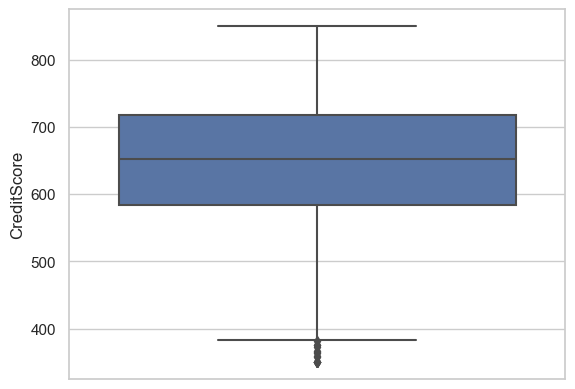

In [11]:
# Plotting CreditScore
sns.set(style="whitegrid")
sns.boxplot(y=dc['CreditScore'])

<AxesSubplot: ylabel='Age'>

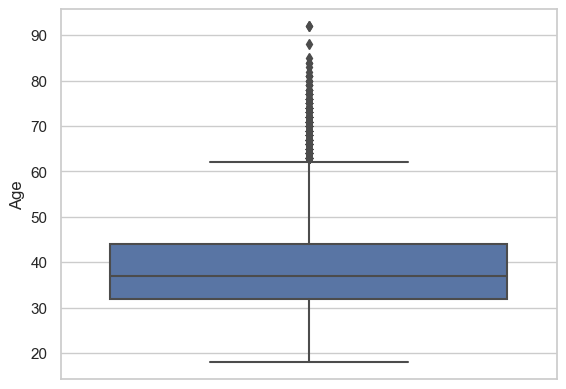

In [12]:
# Plotting Age
sns.boxplot(y=dc['Age'])

<AxesSubplot: ylabel='Tenure'>

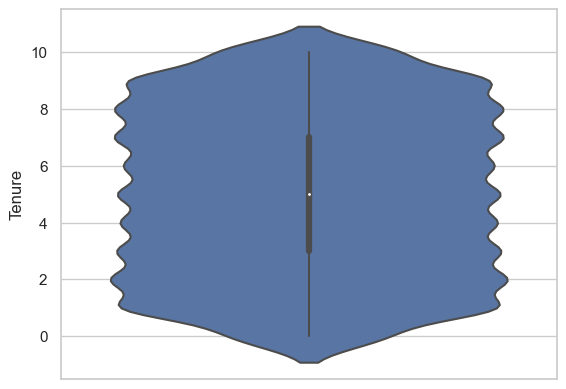

In [13]:
# Tenure violin plot
sns.violinplot(y = dc.Tenure)

<AxesSubplot: ylabel='Balance'>

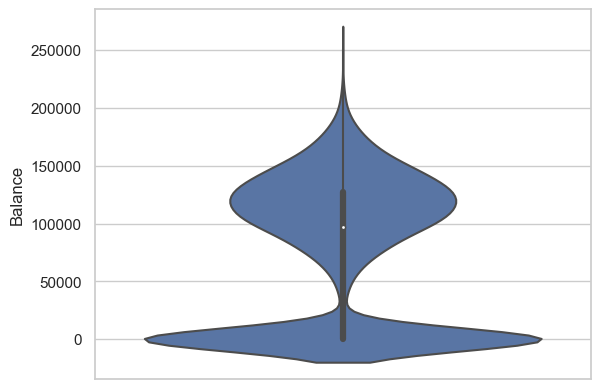

In [14]:
# Balance violin plot
sns.violinplot(y = dc['Balance'])

<AxesSubplot: xlabel='NumOfProducts'>

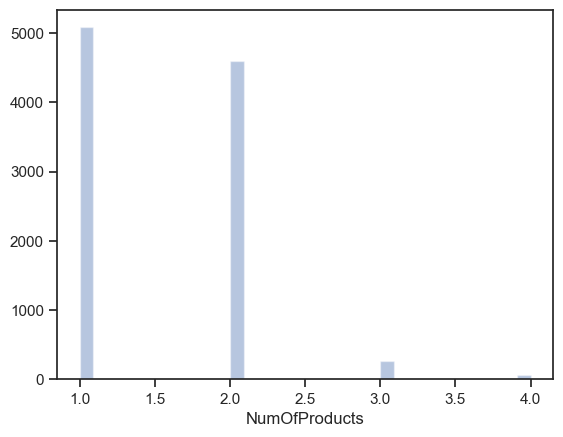

In [15]:
# Plotting a distribution plot of NumOfProducts
sns.set(style = 'ticks')
sns.distplot(dc.NumOfProducts, hist=True, kde=False)

- Most of the customers have 1 or 2 products.

<AxesSubplot: xlabel='EstimatedSalary', ylabel='Density'>

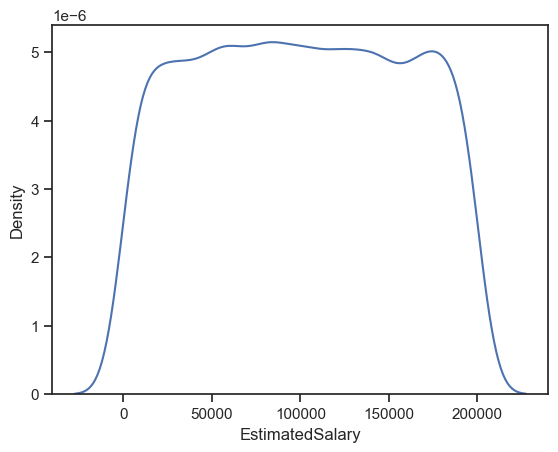

In [16]:
# Kernel density estimation plot for EstimatedSalary
# When dealing with numerical characteristics, one of the most useful statistics to examine is the data distribution.
# we can use Kernel-Density-Estimation plot for that purpose. 
sns.kdeplot(dc.EstimatedSalary)

### Data Preprocessing

Tips:

- We will discard the RowNumber column.
- We will discard CustomerID as well since it doesn't convey any extra info. Each row pertains to a unique customer.
- Features can be segregated into non-essential, numerical, categorical, and target variables based on the above.
- CustomerID is a handy feature based on which we can calculate many user-centric features.

In [17]:
# Separating out different columns into various categories as defined above
target_var = ['Exited']
cols_to_remove = ['RowNumber', 'CustomerId']
# numerical columns
num_feats = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
# categorical columns
cat_feats = ['Surname', 'Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

- Tenure and NumOfProducts are ordinal variables. 
- HasCrCard and IsActiveMember are binary categorical variables.

In [18]:
# Separating target variable and removing the non-essential columns
y = dc[target_var].values
dc.drop(cols_to_remove, axis=1, inplace=True)

### Splitting Dataset

- We keep aside a test set to evaluate our model at the very end to estimate our chosen model's performance on unseen data.
- A validation set is also created, which we'll use in our baseline models to evaluate and tune our models.

In [19]:
# Keeping aside a test/holdout set
dc_train_val, dc_test, y_train_val, y_test = train_test_split(dc, y.ravel(), test_size = 0.1, random_state = 42)

# Splitting into train and validation set
dc_train, dc_val, y_train, y_val = train_test_split(dc_train_val, y_train_val, test_size = 0.12, random_state = 42)
dc_train.shape, dc_val.shape, dc_test.shape, y_train.shape, y_val.shape, y_test.shape
np.mean(y_train), np.mean(y_val), np.mean(y_test)

((7920, 12), (1080, 12), (1000, 12), (7920,), (1080,), (1000,))

(0.20303030303030303, 0.22037037037037038, 0.191)

### Categorical Variable Encoding

- 1- Label Encoding: transforms non-numerical labels into numerical ones. It can be used for binary categorical and ordinal variables.

- 2- One-Hot encoding: encodes categorical features as a one-hot numeric array. It can be used for non-ordinal categorical variables with low to mid cardinality (< 5-10 levels)

- 3- Target encoding: the technique of substituting a categorical value with the mean of the target variable is known as target encoding. The target encoder model automatically removes any non-categorical columns. It can be used for Categorical variables with > 10 levels


- HasCrCard and IsActiveMember are already label encoded.
- Gender, a simple label encoding should be acceptable.
- Geography, since there are three levels, one-hot encoding should do the trick.
- Surname, we'll try target/frequency encoding.

### 1- Label Encoding

#### Label Encoding for Binary Variables
- Label encoding on the Gender column.

In [20]:
# label encoding With  the sklearn method
le = LabelEncoder()
# Label encoding of Gender variable
dc_train['Gender'] = le.fit_transform(dc_train['Gender'])
le_gender_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_gender_mapping

{'Female': 0, 'Male': 1}

#### Testing and validation sets

In [21]:
# Encoding Gender feature for validation and test set
dc_val['Gender'] = dc_val.Gender.map(le_gender_mapping)
dc_test['Gender'] = dc_test.Gender.map(le_gender_mapping)

# Filling missing/NaN values created due to new categorical levels
dc_val['Gender'].fillna(-1, inplace=True)
dc_test['Gender'].fillna(-1, inplace=True)

#### Checking the values on all sets

In [22]:
dc_train.Gender.unique(), dc_val.Gender.unique(), dc_test.Gender.unique()

(array([1, 0]), array([1, 0]), array([1, 0]))

### 2- One-Hot encoding